In [4]:
from landslide4sense.models import Unet
from landslide4sense.data import LandslideDataSet
from landslide4sense.utils.tools import eval_image
from landslide4sense.utils import set_deterministic
from landslide4sense.models import Unet
from landslide4sense import EPSILON
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
import omegaconf
import matplotlib.pyplot as plt
from torch.nn import Upsample, CrossEntropyLoss
import numpy as np
from tqdm import tqdm
import sys
import numba
import random
from landslide4sense.experiments import (
    setup_model,
    setup_datasets
)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
cfg = omegaconf.OmegaConf.load("../conf/config.yaml")
set_deterministic(cfg.train.seed)
cfg

{'data': {'dir': '${hydra:runtime.cwd}/data/', 'train_list': '${hydra:runtime.cwd}/data/train.txt', 'eval_lists_paths': ['${hydra:runtime.cwd}/data/train.txt'], 'eval_names': ['train'], 'test_list': '${hydra:runtime.cwd}/data/valid.txt', 'input_size': [128, 128], 'augmentation': {'module': 'landslide4sense.data.augmentations', 'name': 'transforms'}}, 'model': {'restore_from': '/content/drive/MyDrive/data_science_projects/landslide4sense-2022/models/quiet-salad-43/epoch_4_train_f1=73.748/model.pth', 'module': 'segmentation_models_pytorch', 'name': 'UnetPlusPlus', 'args': {'in_channels': 14, 'classes': 2}}, 'optimizer': {'restore_from': None, 'module': 'torch.optim', 'name': 'Adam', 'args': {'lr': 0.001, 'weight_decay': 0.0005}}, 'loss': {'module': 'segmentation_models_pytorch.losses', 'name': 'DiceLoss', 'args': {'ignore_index': 255, 'mode': 'multiclass'}}, 'train': {'start_epoch': 0, 'steps_per_epoch': 125, 'batch_size': 128, 'num_workers': 2, 'num_steps': 10000, 'num_steps_stop': 1000

In [6]:
model = setup_model(cfg)
interp = torch.nn.Upsample(size=(128, 128), mode="bilinear")

In [7]:
train_dataset = LandslideDataSet(
    "../data/",
    "../data/train_cleaned.txt",
    max_iters=1,
    set="labeled",
)

train_loader: DataLoader[LandslideDataSet] = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=cfg.train.num_workers,
    pin_memory=True,
)

In [8]:
model.eval()
all_preds = []
all_labels = []
pbar = tqdm(
    enumerate(train_loader),
    desc=f"Evaluating on val...",
    total=len(train_loader),
)

num_zeros = 0

for i, batch in pbar:
    image, label, _, name = batch
    label = label.squeeze().numpy().astype(np.uint8)
    image = image.float().to(device)

    with torch.no_grad():
        pred = model(image)

    pred = interp(F.softmax(pred, dim=1)).half().detach()
    all_preds.append(pred)
    all_labels.append(label)

Evaluating on val...:   0%|          | 0/2481 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
Evaluating on val...: 100%|██████████| 2481/2481 [08:52<00:00,  4.66it/s]


In [9]:
preds = torch.cat(all_preds).numpy()
labels = np.array(all_labels)
labels.shape

(2481, 128, 128)

In [10]:
def evaluate(y_pred, y_true):
    TP, FP, TN, FN, n_valid_sample = eval_image(
        y_pred.astype(np.uint8).squeeze().reshape(-1) , 
        y_true.astype(np.uint8).squeeze().reshape(-1), 
        2
    )

    OA = np.sum(TP[1]) * 1.0 / n_valid_sample
    P = np.squeeze((TP[1] * 1.0) / (TP[1] + FP[1] + EPSILON))
    R = np.squeeze((TP[1] * 1.0) / (TP[1] + FN[1] + EPSILON))
    F1 = (2.0 * P * R) / (P + R + EPSILON)
    return OA, P, R, F1

In [11]:
num_classes = 2
num_thresholds = 100

def initialize_arrays(num: int, size: int):
    arrays = []
    for _ in range(num):
        arrays.append(np.zeros((size, 1)))
    return arrays

thrs, f1s, ps, rs, oas = initialize_arrays(5, num_thresholds)

for i, thr in tqdm(enumerate(np.linspace(.1, .9, num_thresholds)), total=num_thresholds):
    y_pred = (preds[:, 1, :, :] > thr)
    OA, P, R, F1 = evaluate(y_pred, labels)
    thrs[i] = thr
    oas[i] = OA
    ps[i] = P
    rs[i] = R
    f1s[i] = F1

100%|██████████| 100/100 [03:24<00:00,  2.04s/it]


In [12]:
optimal_thr = np.squeeze(thrs[f1s.argmax()])
optimal_thr

array(0.35050505)

In [13]:
best_f1 = f1s.max()
best_f1

0.7419906786474864

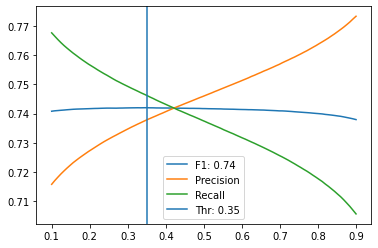

In [15]:
plt.plot(thrs, f1s, label=f"F1: {np.round(best_f1,2 )}")
plt.plot(thrs, ps, label="Precision")
plt.plot(thrs, rs, label="Recall")
#plt.xlim(optimal_thr - .3, optimal_thr + .3)
plt.axvline(optimal_thr, label=f"Thr: {np.round(optimal_thr, 2)}")
plt.legend()
plt.show()

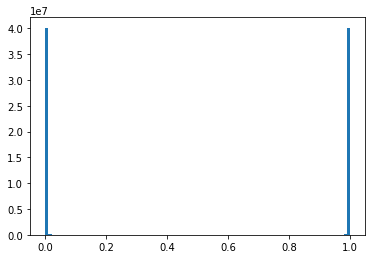

In [38]:
plt.hist(preds.squeeze().reshape(-1), bins=100)
plt.show()

# Visualiation

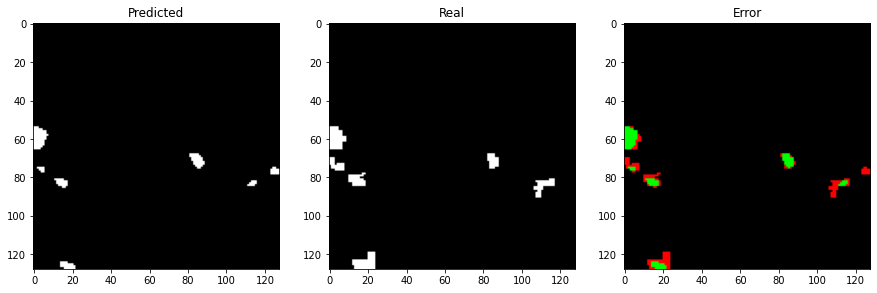

In [98]:
index = 52

predicted = (preds[index, 1, ...] > optimal_thr).astype('uint8')
real = labels[index, ...]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
ax[0].imshow(predicted, cmap="gray")
ax[0].set_title("Predicted")

ax[1].imshow(real, cmap="gray")
ax[1].set_title("Real")

error = np.zeros((*real.shape, 3))

error[..., 0] = (real != predicted)
error[..., 1] = (real == 1) & (real == predicted)
ax[2].imshow(error)
ax[2].set_title("Error")

plt.show()

## How many no-mask images do the dataset have?

In [18]:
train_dataset = LandslideDataSet(
    "../data/",
    "../data/train.txt",
    max_iters=1,
    set="labeled",
)

train_loader: DataLoader[LandslideDataSet] = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=cfg.train.num_workers,
    pin_memory=True,
)

In [19]:
zeros = 0
pbar = tqdm(
    enumerate(train_loader),
    desc=f"Evaluating on train...",
    total=len(train_loader),
)
clean_names = []
zero_mask_names = []

for i, batch in pbar:
    image, label, _, name = batch
    pixel_sum = label.sum()
    if pixel_sum == 0:
        zeros += 1
        zero_mask_names.append(name[0])
    else:
        clean_names.append(name[0])
    perc = (zeros / (i+1)) * 100
    perc = round(perc, 2)
    pbar.set_description(f"perc. of zeros = {perc}%")

perc. of zeros = 41.26%: 100%|██████████| 3800/3800 [01:03<00:00, 59.91it/s]


In [20]:
random.shuffle(zero_mask_names)

In [23]:
desired_perc_zero_mask = 0.1
num_selected_zero_mask = int((desired_perc_zero_mask * len(clean_names)) / (1 - desired_perc_zero_mask))
num_selected_zero_mask

248

In [24]:
selected_zero_mask_names = zero_mask_names[:num_selected_zero_mask]

In [25]:
cleaned_names = selected_zero_mask_names + clean_names

In [27]:
len(selected_zero_mask_names) / len(cleaned_names)

0.1

In [28]:
random.shuffle(cleaned_names)

In [29]:
with open("/content/drive/MyDrive/data_science_projects/landslide4sense-2022/data/train_cleaned.txt", "w") as f:
    for name in cleaned_names:
        f.write(name + "\n")

In [30]:
len(cleaned_names)

2480

In [32]:
train_dataset = LandslideDataSet(
    "../data/",
    "../data/train_cleaned.txt",
    max_iters=1,
    set="labeled",
)

train_loader: DataLoader[LandslideDataSet] = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=cfg.train.num_workers,
    pin_memory=True,
)

zeros = 0
pbar = tqdm(
    enumerate(train_loader),
    desc=f"Evaluating on train...",
    total=len(train_loader),
)
clean_names = []
zero_mask_names = []

for i, batch in pbar:
    image, label, _, name = batch
    pixel_sum = label.sum()
    if pixel_sum == 0:
        zeros += 1
        zero_mask_names.append(name[0])
    else:
        clean_names.append(name[0])
    perc = (zeros / (i+1)) * 100
    perc = round(perc, 2)
    pbar.set_description(f"perc. of zeros = {perc}%")

2232